# Graph theory 2: Hamiltonian cycles
BS Vương Kiến Thanh

Nhớ lại Konisberg city. Ta có thể đổi câu hỏi một chút: Ta có thể từ nhà, đi hết tất cả các địa điểm, rồi về nhà? ( không cần qua hết tất cả cây cầu).  
Vấn đề quan tâm ở đây là đi hết tất cả nodes rồi quay về node ban đầu.  
Còn eulerian là đi hết edges rồi quay về node ban đầu.  
Đây gọi là Hamiltonian cycle.  
Hamiltonian path thì không cần quay về node ban đầu.  

---
SKIP THESE

In [1]:
import pygraphviz as pgv
import networkx as nx
import graphviz as gv
import numpy as np
from itertools import combinations

def render(G, engine='neato', hamiltonian_edges=None, title="", scale=1.2):
    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        back = 0
    else:
        back = None
    G = nx.nx_agraph.to_agraph(G)
    G.graph_attr['label']=title
    
    #  paint cycle
    if not hamiltonian_edges is None:
        for i in range(len(hamiltonian_edges)-1):
            G.get_edge(hamiltonian_edges[i],
                       hamiltonian_edges[i+1], back).attr['color']='red'
    #  get positions        
    layout = nx.circular_layout(sorted(list(G.nodes())))
    for n in G.nodes():
        p = layout[n] *scale
        G.get_node(n).attr['pos']= f"{p[0]},{p[1]}!"
    
    return gv.Source(G.string(), engine=engine)

# hardcode Traveling Salesman Problem recursively
def TSP(G, start_node):
    passed_nodes = [start_node]
    
    def recur(G,start_node):
        nonlocal passed_nodes
        if len(passed_nodes) == len(G.nodes):
            passed_nodes.append(passed_nodes[0])
        else:
            #  adj nodes of start_node 
            adjn = G.adj[start_node]
            #  get min weight
            n_list = [n for n in adjn if n not in passed_nodes]
            w_list = [int(adjn[n]['weight']) for n in adjn if n not in passed_nodes]
            min_w = min(w_list)
            #  get node list with min weight
            min_n_list = [ n for n,w in zip(n_list,w_list) if w==min_w]
            #  randomly travel if equal weight
            np.random.shuffle(min_n_list) 
            next_node = min_n_list[0]
            passed_nodes.append(next_node)
            recur(G, next_node)
            
    recur(G,start_node)

    sum_weight = 0
    for t in range(len(passed_nodes)-1):
        sum_weight += int(G.edges[passed_nodes[t], passed_nodes[t+1]]['weight'])
    
    return ' '.join(passed_nodes), sum_weight

def make_random_weight(G,a=1,b=10):
    w = dict()
    
    for e1,e2 in combinations(list(G.nodes),2):
        x = np.random.randint(a,b)
        G.edges[e1,e2]['weight'] = x
        w[(e1,e2)]=x
    return w

def undirecting(G):
    uG = G.copy()
    origin_nodes = list(G.nodes)
    
    def add_weight(uG, n1, n2, val):
        uG.edges[n1, n2]['weight']= int(val)
        uG.edges[n1, n2]['label']= str(val)
        
    for node in origin_nodes:
        clone_node = node+'\''
        uG.add_edge(node,clone_node)
        add_weight(uG, node, clone_node, 0)
        
    for e1,e2 in combinations(origin_nodes,2):
        uG.add_edge(e1+"'", e2)
        uG.add_edge(e1, e2+"'")
        add_weight(uG, e1+"'", e2, uG.edges[e1, e2]['weight'])
        add_weight(uG, e1, e2+"'", uG.edges[e2, e1]['weight'])
        uG.remove_edge(e1,e2)
        uG.remove_edge(e2,e1)
    
    uG = uG.to_undirected()
    return uG

END SKIP

---

# 1. Hamiltonian cycle trong Konisberg map

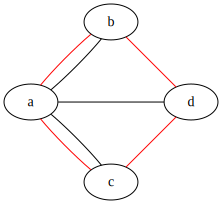

In [2]:
edges = ['ca','ba','ba','ca', 'bd','cd','ad']
K = nx.MultiGraph(edges)
render(K, hamiltonian_edges='bdcab', engine='circo')

### Điều kiện dễ hơn, chỉ cần qua nodes, nhưng cũng vì thể là algorithm để tìm hamiltonian cycle phức tạp hơn.  
Ví dụ:

#### a. Graph này có eulerian circuit nhưng không có hamiltonian cycle vì node C không quay lại B được để qua về node ban đầu.

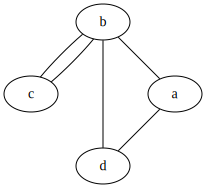

In [3]:
edges = ['ab', 'ad','bd', 'bc','bc']
G = nx.MultiGraph(edges)
render(G, scale=1)

In [4]:
nx.is_eulerian(G)

True

#### b. Graph này vừa có eulerian circuit vừa có hamiltonian cycle.

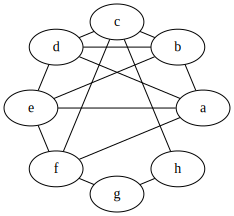

In [5]:
edges = ['af','ae','ad','ab', 'bc', 'be','bd','fc', 'de','fe','cd', 'gh','hc','fg']
G = nx.Graph(edges)
render(G)

In [6]:
nx.is_eulerian(G)

True

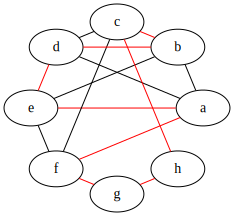

In [7]:
render(G, hamiltonian_edges='aedbchgfa')

#### c. Graph này không có eulerian circuit nhưng có hamiltonian cycle.

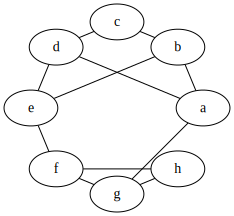

In [8]:
edges = ['ba', 'bc', 'cd', 'ad','ag', 'be','de','fe','gf','hg','hf']
G = nx.Graph(edges)
render(G) 

In [9]:
# vì có 3 nodes là odd
nx.is_eulerian(G)

False

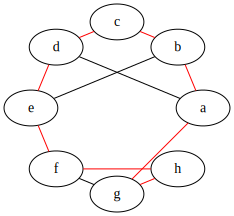

In [10]:
render(G, hamiltonian_edges='abcdefhga')

#### d. Và graph này không có eulerian circuit và cũng không có hamiltonian cycle vì node D chỉ có 1 edge.

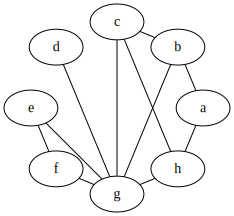

In [11]:
edges = ['ab', 'bc','ch', 'ha','gb','gc','gh','ge','gd','gf','ef']
G = nx.Graph(edges)
render(G)

In [12]:
# Vì có nhiều node lẻ
nx.is_eulerian(G)

False

# 2. Một số điều kiện cần để có Hamiltonian cycle:
- G là connected graph ( tức là không có node cô lập).
- Mọi nodes phải có degree >=2.
- Không có cut-vertex, tức là mất node đó làm graph chia làm 2.

Đây chỉ là điều kiện cần, chưa phải điều kiện đủ.  
Một số điều kiện đủ được đưa ra, tuy nhiên không phải tẩt cả các hamiltonian cycle đều có tính chất này.

#### Dirac's theorem: 
- Let G be a graph with n ≥ 3 vertices. If every vertex of G satisﬁes deg(v) ≥ n/2 , then G has a Hamiltonian cycle.

#### a. Graph này thoả Dirac's theorem nên có hamiltonian cycle

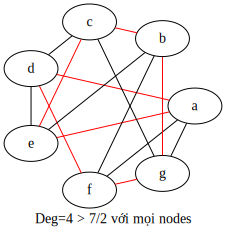

In [13]:
edges = ['ag','af','ae','ad','bg','bf','be','bc','cg','cd','ce','de','df','fg']
G = nx.Graph(edges)
render(G, hamiltonian_edges='bceadfgb', title='Deg=4 > 7/2 với mọi nodes')

#### b. Graph này không thoả Dirac's theorem nhưng vẫn có Hamiltonian cycle

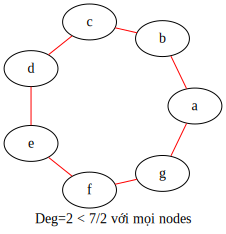

In [14]:
edges = ['ab','bc','cd','de','ef','fg','ga']
G = nx.Graph(edges)
render(G, hamiltonian_edges='abcdefga', title='Deg=2 < 7/2 với mọi nodes')

# 3. Ở bài này, chúng ta không tập trung tìm xen graph có hamiltonian cycle không, thay vì đó ta sẽ học cách tìm một hamiltonian cycle ở một graph đặc biệt là COMPLETE GRAPH

Một complete graph có mọi cặp nodes đều là adjacent, được ký hiệu là K(n).

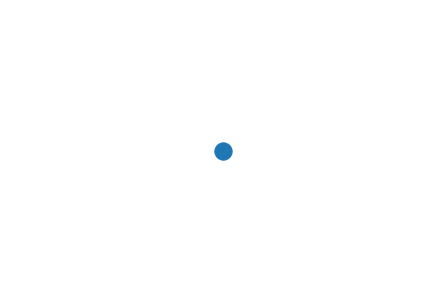

In [15]:
nx.draw(nx.complete_graph(1))

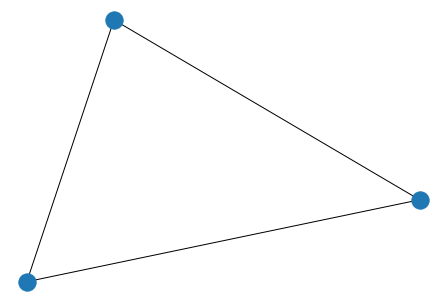

In [16]:
nx.draw(nx.complete_graph(3))

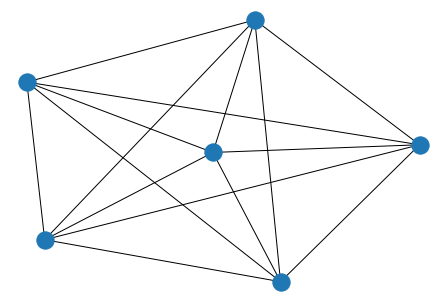

In [17]:
nx.draw(nx.complete_graph(6))

Properties of K(n)
1. Each vertex in K n has degree n − 1.
2. K(n) has $\frac{n(n-1)}{2}$ edges
3. K(n) contains the most edges out of all simple graphs on n vertices.

K(n) thoả Dirac's Theorem nên có hamiltonian cycle. Chúng ta có thể dễ dàng đếm số hamiltonian cycles trong K(n).  
Với 1 điểm bắt đầu, số lượng Hamiltonian cycles trong complete graph = (n-1)!. Một phần hai số đó là vòng ngược lại.

Ví dụ:  
K(3) từ node a có 2 hamitonian cycles: abc, acb
K(4) từ node a có 6 hamitonian cycles: abcd, abdc, acbd, acdb, adbc, adcb

# 4. Traveling Salesman Problem
Một salesman phải gặp tất cả khách hàng tại một thành phố và về nhà. Anh ấy phải chọn con đường sao cho ít tốn kém nhất.

Bài toán này là model theo dạng weighted complete graph.

#### a. Brute Force
Ta tìm tất cả hamiltonian cycles trong weighted complete graph. Sau đó tìm min(). Cách này cho kết quả chính xác, tuy nhiên số lần tìm cycle sẽ tăng cực kỳ nhanh theo giai thừa của số nodes.

Brute force là không hợp cho bài toán có **20 nodes trở lên**.

|n|Best Supercomputer cost time|
|-|-|
|20|40s|
|21|14m|
|22|5h|
|23|4.5d|
|26|2 centuries|

=> Có những thuật toán khác có thể giải bài toán TSP một cách tương đối
#### b. Nearest Neighbor
Cho một node bắt đầu, ta tìm edge có weight thấp nhất rồi đi tiếp, cho đến khi đi hết nodes là ra hamiltonian cycles.

dict_values([8, 8, 4, 3, 5, 1, 5, 4, 6, 8])


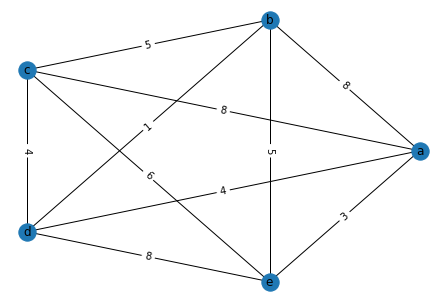

In [18]:
G = nx.complete_graph(list('abcde'))
layout = nx.circular_layout('abcde')

weight = make_random_weight(G)
nx.draw(G, pos=layout, with_labels=True)
nx.draw_networkx_edge_labels(G,pos=layout, edge_labels=weight)
print(weight.values())

In [19]:
a, b = TSP(G,'a')
print(f"Hamiltonian cycle = {a}\nSum weight = {b}")

Hamiltonian cycle = a e b d c a
Sum weight = 21


#### c. Repetitive Nearest Neighbor Algorithm
Áp dụng thuật toán trên, khởi đầu bằng từng node một đến toàn bộ nodes, rồi tìm min().

In [20]:
for n in G.nodes:
    print(f'Start with {n}:',TSP(G,n))

Start with a: ('a e b d c a', 21)
Start with b: ('b d c e a b', 22)
Start with c: ('c d b e a c', 21)
Start with d: ('d b e a c d', 21)
Start with e: ('e a d b c e', 19)


#### d. Ngoài ra còn có cheapest link;  nearest insertion algorithm 

# 5. DiGraph
Ở Digraph, edge được gọi là arc.  
G = (V, A)  
Arc là ordered edge.  
Arc (a, b) có head=a, tail=b  
Node a có in-degree là số lượng arcs vào node, ký hiệu deg$^-$(a)  
Node a có out-degree là số lượng arcs vào node, ký hiệu deg$^+$(a)  
Underlying graph là digraph nhưng edge không có hướng.  
Directed path là đường đi của các nodes với các edge cùng 1 hướng.  
Directed cycle là directed path có vòng xoay.

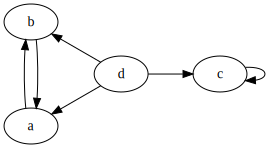

In [21]:
edges = ['ab','ba','da','db','dc','cc']
G = nx.MultiDiGraph(edges)
render(G, engine='circo')

#### Theorem Handshaking Lemma:
Tổng deg$^-$ = Tổng deg$^+$ = Tổng số arc.

# 6. Một số điều kiện để Digraph có hamiltonian cycle
1. G là connected graph
2. Mọi node có deg$^-$ và deg$^+$ khác 0
3. G không có cut-vertex

#### Dirac's theorem
Nếu Digraph có mọi nodes có deg$^-$ và deg$^+$  >= n/2, thì Digraph có hamiltonian cycle.

# 7. Tìm Hamiltonian cycle trong complete digraph ( Asymetrical Traveling Salesman Problem)
Thay vì dùng một thuật toán mới, ta chỉ cần xoá hướng trong Complete digraph bằng cách:  
1. Tạo một node giả kế bên node thiệt, ví dụ a và a'
2. Arc( a, a' ) có weight =0.
3. Khi có  w(a,b') = w(a,b);  w(b,a')= w(b,a)
4. Bỏ vào TSP cho non-directed graph

Note: undirected complete Digraph, khi đó không còn complete nữa, tuy nhiên vẫn thoả Dirac's theorem nên vẫn có hamiltonian cycle.

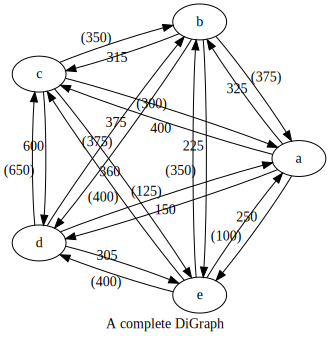

In [22]:
G = pgv.AGraph('sample_dot/asym_TSP.gv')
G = nx.DiGraph(G)

for (e1,e2) in combinations(list(G.nodes),2):
    G.edges[e1,e2]['label'] = G.edges[e1,e2]['weight']
    G.edges[e2,e1]['label'] = '('+G.edges[e2,e1]['weight'] +")"

render(G, title='A complete DiGraph', scale=2)

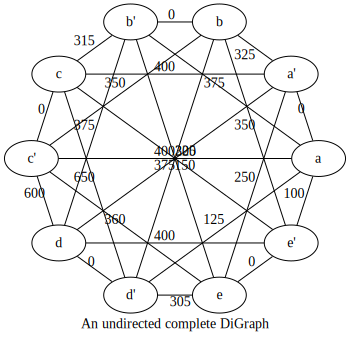

In [23]:
uG = undirecting(G)
render(uG, title='An undirected complete DiGraph', scale=2)

In [24]:
for n in uG.nodes:
    print(f'Start with {n}:',TSP(uG,n))

Start with a: ("a a' d d' e e' b b' c c' a", 1420)
Start with b: ("b b' e e' a a' d d' c c' b", 1475)
Start with c: ("c c' a a' d d' e e' b b' c", 1420)
Start with d: ("d d' a a' e e' b b' c c' d", 1640)
Start with e: ("e e' a a' d d' b b' c c' e", 1300)
Start with a': ("a' a e' e b' b c' c d' d a'", 1475)
Start with b': ("b' b a' a e' e d' d c' c b'", 1645)
Start with c': ("c' c b' b a' a e' e d' d c'", 1645)
Start with d': ("d' d a' a e' e b' b c' c d'", 1475)
Start with e': ("e' e b' b a' a d' d c' c e'", 1675)


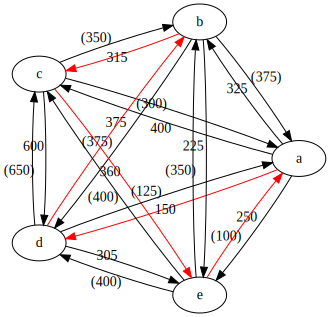

In [25]:
cycle = 'eadbce' # best path

render(G, scale=2, hamiltonian_edges=cycle)

In [26]:
100+150+375+315+360

1300

#### Những thuật toán khác là: 
- Undirecting sau đó cheapest link
- Farthest Insertion